## Tacotron 2 inference code 
Edit the variables **checkpoint_path** and **text** to match yours and run the entire code to generate plots of mel outputs, alignments and audio synthesis from the generated mel-spectrogram using Griffin-Lim.

#### Import libraries and setup matplotlib

In [1]:
import matplotlib
%matplotlib inline
import matplotlib.pylab as plt

import IPython.display as ipd

import sys
sys.path.append('waveglow/')
import numpy as np
import torch

from hparams import create_hparams
from model import Tacotron2
from layers import TacotronSTFT, STFT
from audio_processing import griffin_lim
from train import load_model
from text import text_to_sequence
from waveglow.denoiser import Denoiser

In [2]:
def plot_data(data, figsize=(16, 4)):
    fig, axes = plt.subplots(1, len(data), figsize=figsize)
    for i in range(len(data)):
        axes[i].imshow(data[i], aspect='auto', origin='bottom', 
                       interpolation='none')

#### Setup hparams

In [3]:
hparams = create_hparams()
hparams.sampling_rate = 22050


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



#### Load model from checkpoint

In [4]:
checkpoint_path = "checkpoint_4000"
model = load_model(hparams)
model.load_state_dict(torch.load(checkpoint_path)['state_dict'])
_ = model.cuda().eval().half()

#### Load WaveGlow for mel2audio synthesis and denoiser

In [4]:
waveglow_path = 'waveglow_256channels.pt'
waveglow = torch.load(waveglow_path)['model']
waveglow.cuda().eval().half()
for k in waveglow.convinv:
    k.float()
denoiser = Denoiser(waveglow)

C:\Users\Administrator\Anaconda3\lib\site-packages\torch\serialization.py:434: SourceChangeWarning: source code of class 'torch.nn.modules.conv.ConvTranspose1d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\torch\serialization.py:434: SourceChangeWarning: source code of class 'torch.nn.modules.container.ModuleList' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\torch\serialization.py:434: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv1d' has changed. you can retrieve the original source code by access

#### Prepare text input

In [12]:
text = "Tęstuojame modely. testuojamę. Vel testuojame. Ar galėtume dar pailginti? Bandom."
sequence = np.array(text_to_sequence(text, ['basic_cleaners']))[None, :]
sequence = torch.autograd.Variable(
    torch.from_numpy(sequence)).cuda().long()

#### Decode text input and plot results

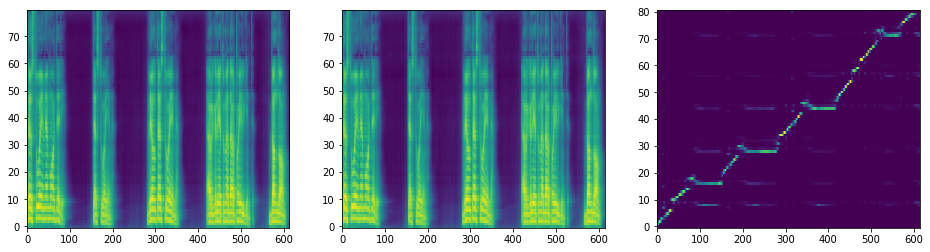

In [16]:
mel_outputs, mel_outputs_postnet, _, alignments = model.inference(sequence)
plot_data((mel_outputs.float().data.cpu().numpy()[0],
           mel_outputs_postnet.float().data.cpu().numpy()[0],
           alignments.float().data.cpu().numpy()[0].T))

In [19]:
torch.save(mel_outputs_postnet, "mel.pt")

In [5]:
mel_outputs_postnet = torch.load("mel.pt").cuda().half()

#### Synthesize audio from spectrogram using WaveGlow

In [6]:
with torch.no_grad():
    audio = waveglow.infer(mel_outputs_postnet, sigma=0.666)
ipd.Audio(audio[0].data.cpu().numpy(), rate=hparams.sampling_rate)

C:\Users\Administrator\Anaconda3\lib\site-packages\torch\nn\modules\module.py:489: RuntimeWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  result = self.forward(*input, **kwargs)
C:\Users\Administrator\Anaconda3\lib\site-packages\torch\nn\modules\module.py:489: RuntimeWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  result = self.forward(*input, **kwargs)


RuntimeError: 
CUDA out of memory. Tried to allocate 9.63 MiB (GPU 0; 1024.00 MiB total capacity; 393.71 MiB already allocated; 8.30 MiB free; 67.79 MiB cached) (malloc at ..\aten\src\THC\THCCachingAllocator.cpp:231)
(no backtrace available):
operation failed in interpreter:
@torch._jit_internal.weak_script
def sigmoid(input):
    r"""sigmoid(input) -> Tensor

    Applies the element-wise function :math:`\text{Sigmoid}(x) = \frac{1}{1 + \exp(-x)}`

    See :class:`~torch.nn.Sigmoid` for more details.
    """
    warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
    return input.sigmoid()
           ~~~~~~~~~~~~~ <--- HERE


#### (Optional) Remove WaveGlow bias

In [9]:
audio_denoised = denoiser(audio, strength=0.01)[:, 0]
ipd.Audio(audio_denoised.cpu().numpy(), rate=hparams.sampling_rate) 